In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import time
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from src.utils import *
from src.loss import *
from src.model import *
from src.dataset import *

In [2]:
"""kitti_ds = KittiStereoLidar(
    im_left_dir=glob.glob("data/left_imgs/2011_09_26_drive_0001_sync/*"), 
    im_right_dir=glob.glob("data/right_imgs/2011_09_26_drive_0001_sync/*"),
    gt_left_dir=glob.glob("data/left_gt/2011_09_26_drive_0001_sync/*"), 
    gt_right_dir=glob.glob("data/right_gt/2011_09_26_drive_0001_sync/*"),
    transform=transforms.Compose([transforms.Resize((192,640)),
                                  transforms.ToTensor()])
)"""
kitti_ds = KittiStereoLidar(
    im_left_dir=glob.glob("data/left_imgs/*/*"), 
    im_right_dir=glob.glob("data/right_imgs/*/*"),
    gt_left_dir=glob.glob("data/left_gt/*/*"), 
    gt_right_dir=glob.glob("data/right_gt/*/*"),
    transform=transforms.Compose([transforms.Resize((192,640)),
                                  transforms.ToTensor()])
)
# 2011_09_26_drive_0001_sync/
# Resize issues
# Original(375,1242)
# (384, 1280)->(160,320)
# (192,640)->(96,320)

In [3]:
print(len(kitti_ds))
batch_size = 4
train_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=6)
 
dataiter = iter(train_loader) #21972

21972


In [4]:
# Depth prediction networks for left & right view sets respectively
L = Network()
L = torch.nn.DataParallel(L).cuda()

In [5]:
#Precalculate mapping parameters
sc = 320/1242
reconstruct_functions = [Reconstruction(date='2011_09_26',scaling=sc), 
                         Reconstruction(date='2011_09_28',scaling=sc),
                         Reconstruction(date='2011_09_29',scaling=sc), 
                         Reconstruction(date='2011_09_30',scaling=sc),
                         Reconstruction(date='2011_10_03',scaling=sc)]

def normalize_prediction(map_input, scale=100):
    M, m=np.amax(map_input), np.amin(map_input)
    return (map_input - m)*(scale / (M-m))

def get_unsu_loss(depth_maps, src_imgs, tar_imgs, direction, dates):
    
    batch_loss = 0
    for[dep, src, tar, dat] in zip(depth_maps, src_imgs, tar_imgs, dates):
        if dat=='2011_09_26':
            recf = reconstruct_functions[0]
        elif dat=='2011_09_28':
            recf = reconstruct_functions[1]
        elif dat=='2011_09_29':
            recf = reconstruct_functions[2]
        elif dat=='2011_09_30':
            recf = reconstruct_functions[3]
        elif dat=='2011_10_03':
            recf = reconstruct_functions[4]

        # Calculate sample loss
        sample_loss, img = recf.compute_loss(dep, src, tar, direction)
        batch_loss += sample_loss

    return batch_loss / batch_size, img

def get_su_loss(depth_maps, scan_files):
    
    batch_loss = 0
    for[dep, scan_file] in zip(depth_maps, scan_files):
        dots = np.load(scan_file) 

        sample_loss = gt_loss(dep, dots)
        batch_loss += sample_loss

    return batch_loss / batch_size

In [6]:
n_epochs = 20
alpha = 1
beta = 1
lr = 1e-3
L_optimizer = torch.optim.Adam(L.parameters(), lr=lr)

In [7]:
L.train()
img=None
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    batch_count = 1
    print_every = 200
    time_start = time.time()

    for images_l, images_r, scans_l, scans_r in train_loader: #images_l: torch.Size([batch_size, 3, 197, 645])
        L_optimizer.zero_grad()
        
        # Move to cuda
        images_l = images_l.cuda()
        images_r = images_r.cuda()
        
        # Forward pass, make predictions
        depths_l = L(images_l)

        # Back to numpy
        drive_dates = [s[13:23] for s in scans_l]
        
        # Compute losses
        su_loss_L = get_su_loss(depth_maps=depths_l, scan_files=scans_l)
        #unsu_loss_L2R, img = get_unsu_loss(depth_maps=depths_l, 
        #                              src_imgs=images_l, 
        #                              tar_imgs=images_r, 
        #                              direction='L2R', dates=drive_dates)
        unsu_loss_L2R=0
        
        loss = alpha*su_loss_L + beta*unsu_loss_L2R

        # Back propagation & optimize
        loss.backward()
        L_optimizer.step()

        train_loss += loss.item()
        step_loss = train_loss / (batch_count * batch_size)
        if batch_count % print_every == 0:
            print('Epoch: {} \tStep Loss: {:.6f} \n\tSu: {:.6f}'.format(
                epoch+1, 
                step_loss,
                su_loss_L
            ))
        batch_count += 1

    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler) #image pair count
    time_elapsed = time.time() - time_start

    print('Epoch: {} \tTraining Loss: {:.6f} \tTime: {} s'.format(
        epoch+1, 
        train_loss,
        round(time_elapsed, 4)
        ))


Epoch: 1 	Step Loss: 0.001301 
	Su: 0.001524
Epoch: 1 	Step Loss: 0.000839 
	Su: 0.001955
Epoch: 1 	Step Loss: 0.000682 
	Su: 0.001510
Epoch: 1 	Step Loss: 0.000605 
	Su: 0.001315
Epoch: 1 	Step Loss: 0.000557 
	Su: 0.001410
Epoch: 1 	Step Loss: 0.000526 
	Su: 0.001218
Epoch: 1 	Step Loss: 0.000503 
	Su: 0.001128
Epoch: 1 	Step Loss: 0.000486 
	Su: 0.001356
Epoch: 1 	Step Loss: 0.000472 
	Su: 0.001315
Epoch: 1 	Step Loss: 0.000461 
	Su: 0.001548
Epoch: 1 	Step Loss: 0.000451 
	Su: 0.001364
Epoch: 1 	Step Loss: 0.000444 
	Su: 0.001616
Epoch: 1 	Step Loss: 0.000437 
	Su: 0.001761
Epoch: 1 	Step Loss: 0.000432 
	Su: 0.002081
Epoch: 1 	Step Loss: 0.000428 
	Su: 0.001585
Epoch: 1 	Step Loss: 0.000424 
	Su: 0.001352
Epoch: 1 	Step Loss: 0.000421 
	Su: 0.001431
Epoch: 1 	Step Loss: 0.000419 
	Su: 0.001726
Epoch: 1 	Step Loss: 0.000416 
	Su: 0.001475
Epoch: 1 	Step Loss: 0.000414 
	Su: 0.001632
Epoch: 1 	Step Loss: 0.000412 
	Su: 0.001219
Epoch: 1 	Step Loss: 0.000410 
	Su: 0.001134
Epoch: 1 	

Epoch: 7 	Step Loss: 0.000322 
	Su: 0.001288
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.001387
Epoch: 7 	Step Loss: 0.000322 
	Su: 0.001337
Epoch: 7 	Step Loss: 0.000322 
	Su: 0.001137
Epoch: 7 	Step Loss: 0.000322 
	Su: 0.001184
Epoch: 7 	Step Loss: 0.000322 
	Su: 0.001543
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.001213
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.000968
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.001493
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.001415
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.001559
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.001391
Epoch: 7 	Step Loss: 0.000321 
	Su: 0.001567
Epoch: 7 	Training Loss: 0.000320 	Time: 1937.8279 s
Epoch: 8 	Step Loss: 0.000316 
	Su: 0.001160
Epoch: 8 	Step Loss: 0.000313 
	Su: 0.001150
Epoch: 8 	Step Loss: 0.000313 
	Su: 0.001302
Epoch: 8 	Step Loss: 0.000314 
	Su: 0.000998
Epoch: 8 	Step Loss: 0.000314 
	Su: 0.001197
Epoch: 8 	Step Loss: 0.000313 
	Su: 0.001325
Epoch: 8 	Step Loss: 0.000313 
	Su: 0.001111
Epoch: 8 	Step Loss: 0.000312 
	Su: 0.000932
Ep

Epoch: 13 	Step Loss: 0.000286 
	Su: 0.000831
Epoch: 13 	Step Loss: 0.000286 
	Su: 0.000871
Epoch: 13 	Training Loss: 0.000286 	Time: 1895.8314 s
Epoch: 14 	Step Loss: 0.000283 
	Su: 0.001032
Epoch: 14 	Step Loss: 0.000283 
	Su: 0.000878
Epoch: 14 	Step Loss: 0.000281 
	Su: 0.001240
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001015
Epoch: 14 	Step Loss: 0.000281 
	Su: 0.000762
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001143
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.000940
Epoch: 14 	Step Loss: 0.000281 
	Su: 0.001283
Epoch: 14 	Step Loss: 0.000281 
	Su: 0.001015
Epoch: 14 	Step Loss: 0.000281 
	Su: 0.001279
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001050
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001123
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001195
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.000988
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001096
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001128
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001164
Epoch: 14 	Step Loss: 0.000282 
	Su: 0.001273
Epoch: 14 	Step Loss: 0.00

Epoch: 20 	Step Loss: 0.000264 
	Su: 0.001342
Epoch: 20 	Step Loss: 0.000264 
	Su: 0.001136
Epoch: 20 	Step Loss: 0.000264 
	Su: 0.001197
Epoch: 20 	Step Loss: 0.000264 
	Su: 0.000737
Epoch: 20 	Step Loss: 0.000264 
	Su: 0.001080
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001276
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001233
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001005
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001157
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001038
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.000866
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.000867
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.000982
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.000956
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.000889
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001399
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.000852
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001230
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001247
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.001019
Epoch: 20 	Step Loss: 0.000263 
	Su: 0.000989
Epoch: 20 	Training Loss: 0.000263

In [8]:
#r = np.transpose(img.cpu().detach().numpy(), (1,2,0))
#plt.imshow(r)
#plt.show()

In [9]:
test_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=6)
 
dataiter = iter(train_loader) #21972

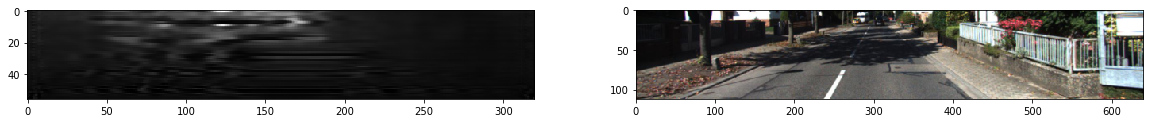

In [15]:
images_l, images_r, scans_l, scans_r = dataiter.next()
depths_l = L(images_l)
npd = np.transpose(depths_l[0].cpu().detach().numpy(), (1,2,0)).squeeze()
npi = np.transpose(images_l[0].cpu().detach().numpy(), (1,2,0))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.imshow(npd[40:, :], cmap='gray')
ax2.imshow(npi[80:, :, :])
plt.show()

In [13]:
np.amax(npd), np.amin(npd)

(0.9999782, 1.0127654e-05)